## HOURLY ELECTRICITY PRICE FORECASTING MODEL

##### REQUIRED LIBRARIES

In [1]:
# Import required libraries
from tqdm import tqdm_notebook,tqdm
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot as plt
import numpy
import os
import platform

Using TensorFlow backend.


##### REQUIRED FUNCTIONS

In [2]:
def load_bergen_data(years = ['2013','2014','2015','2016','2017'], mkt='Bergen'):
    """
    load_bergen_data function
    
    This function extracts annual datasets of hourly electricity price (source North Pool).
    It loads only Bergen
    
    Args:
        1) years -> list of dataset to be included in trainset and validationset
        2) mkt -> which spot price of the North Pool is going to be predicted
    Out:
        1) hourly electricity price dataset of the selected region
    """
    file_name_1 = 'elspot-prices_'
    file_name_2 = '_hourly_dkk.csv'
    if platform.system()=='Linux':
        data_folder = os.getcwd().replace('notebook','data/')
    else:
        data_folder = os.getcwd().replace('notebook','data\\')
    
    all_data=[]
    for year in years:
        file_name_tot = data_folder + file_name_1 + year + file_name_2
        all_data.append(pd.read_csv(file_name_tot,encoding = "ISO-8859-1",sep=';',decimal=','))
    df = pd.concat(all_data, ignore_index=True,sort= True)
    df = df[['datetime','Hours',mkt]]
    return df

In [54]:

def timeseries_to_supervised(data, lag=1):
    """
    This function frames a sequence as a supervised learning problem
    
    Args:
        1) data --> time series
        2) lag --> number of lagged features to be generated
    Out:
        1) df -> dataframe containing all the lagged features (from the more recent to the more lagged)
                 the last column of the dataframe is the initial time series (target of the supervised learning model)
    
    Lagged features are generated as continous in time. Id est, if 3 is the number of lagged features and t is the actual time, 
    generated features will be the actual series lagged at t-1, t-2, t-3
    """
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    #df = df.dropna()
    return df

# 
def difference(dataset, interval=1):
    """
    This function create a differenced series to remove seasonality effects
    
    Args:
        1) dataset -> time series
    Out:
        1) Pandas Series of the differenced initial dataframe
    """
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval):
    """
    This function invert differenced values.
    
    Args:
        1) history -> time series to be predicted
        2) yhat -> predicted value
        3) interval -> difference interval
    
    Out:
        1) Anti-transformed predicted value
    """
    return yhat + history.iloc[-interval]

def scale(train, test):
    """
    This function scale train and test data to [-1, 1]
    
    Args:
        1) train --> train dataset
        2) test --> test dataset
        
    Out:
        1) scaler -> to be user to scale or unscale with the same tuned parameters
        2) train_scaled -> scaled trainset
        3) test_scaled -> scaled testset
    """
    
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled


def invert_scale(scaler, X, value):
    """
    This function performs inverse scaling for a forecasted value
    
    Args:
        1) scaler -> fitted scaler with scale() function
        2) X -->
        3) value -->
    Out:
        1) unscaled value
    """
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

def split_features_label(dataset):
    """
    This function splits datafrema in label and features
    
    Args:
        1) dataset -> input dataset, target variable is the last column
    Out:
        1) features -> model features matrix
        2) label -> supervised model label array
    
    IMPORTANT: assumptions about labels:
        1) Only one output (forecast at time t+n, when n is the number of steps ahead)
        2) label array must be the last column of the dataset matrix
        
    """
    features, label = dataset[:, 0:-1], dataset[:, -1]
    features = features.reshape(features.shape[0], 1, features.shape[1])
    return features,label

def fit_lstm(train, val, batch_size, nb_epoch, neurons):
    """
    This function fits an LSTM network to training data
    
    Args:
        1) train --> training dataset
        2) val --> validation dataset
        3) batch_size
        4) nb_epochs --> number of epochs
        5) neurons --> number of neurons in the hidden layer
    
    Out:
        1) model --> trained model
    """
    X, y = split_features_label(train)
    X_val, y_val = split_features_label(val)
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in tqdm_notebook(range(nb_epoch),leave=False):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False, validation_data=(X_val,y_val))
        model.reset_states()
    return model

def forecast_lstm(model, batch_size, X):
    """
    This function makes a one-step forecast
    
    Args:
        1) model --> supervised model (fitted by fit_lstm function)
        2) batch_size
        3) X --> input features
    """
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]


### LSTM MODEL

In [67]:
# features and label definition
n_features = 24 # how many time steps to consider for the analysis
time_interval = 0 # how many hour in advance the modell should make the prediction

# LSTM architecture
neurons = 3
epochs = 5

# internal paramters for the LSTM model
n_shift = n_features + time_interval - 1
n_ahead = range(0,time_interval)

In [68]:
# data loading and feature extraction
df = load_bergen_data()
raw_values = df['Bergen'].dropna()
diff_values = difference(raw_values, interval = time_interval)
supervised = timeseries_to_supervised(diff_values, n_shift)
supervised_values = supervised.values

In [69]:
# train - validation split
validation_share = 0.20
test_size = round(validation_share*supervised_values.shape[0])
train_size = supervised_values.shape[0]-test_size
train, test = supervised_values[0:train_size,:], supervised_values[train_size:,:]
if len(n_ahead)>0:
    train, test = np.delete(train, n_ahead, axis = 1),np.delete(test, n_ahead, axis = 1)

In [70]:
# feature scaling
scaler, train_scaled, test_scaled = scale(train, test)

In [71]:
# Ensemble of models
n_ensemble = 1
lstm_ensemble = list()

In [73]:
# fit the model

for n in tqdm_notebook(range(n_ensemble)):
    lstm_model = fit_lstm(train_scaled,test_scaled, 1, epochs, neurons)
    lstm_ensemble.append(lstm_model)
    lstm_model = []

#### MODEL PERFORMANCE 

In [61]:
def make_predictions(lstm_model,test_scaled):
    """
    This function makes prediction on a test dataset using a fitted LSTM model
    
    Args:
        1) lstm_model -> fitted model
        2) test_scaled -> test dataset already preprocessed and scaled
    Out:
        1) predictions -> model forecasted values for the testset
    
    """
    
    # walk-forward validation on the test data
    predictions = list() 
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
    return predictions

In [62]:
def evaluate_model_performance(lstm_ensemble, test_scaled = test_scaled, raw_values = raw_values):
    """
    This function estimates model performance, calculating relevant metrics
    
    Args:
        1) lstm_ensemble --> a list of models to be evaluated
        2) test_scaled --> test set to be used for metrics calculation
        3) raw_values --> inital unscaled dataset for benchmark
        
    Out:
        1) rmse_ensemble --> a list of RMSE (one for each model)
        2) mae_ensemble --> a list of MAE (one for each model)
        3) predictions_ensemble --> a list of predicted values (one for each model)
    
    This function supports the evaluation of a single model (one-item list)
    
    """
    rmse_ensemble = list()
    mae_ensemble = list()
    predictions_ensemble = list()
    test_samples = test_scaled.shape[0]
    for i in tqdm_notebook(range(len(lstm_ensemble))):
        predictions = make_predictions(lstm_ensemble[i],test_scaled)
        predictions_ensemble.append(predictions)
        rmse = sqrt(mean_squared_error(raw_values[-test_samples:], predictions))
        rmse_ensemble.append(rmse)
        mae = mean_absolute_error(raw_values[-test_samples:], predictions)
        mae_ensemble.append(mae)
    return rmse_ensemble, mae_ensemble, predictions_ensemble    

In [63]:
rmse_ensemble, mae_ensemble, predictions_ensemble = evaluate_model_performance(lstm_ensemble, test_scaled = test_scaled, raw_values = raw_values)

In [64]:
print(np.std(np.array(rmse_ensemble)))
print(np.mean(np.array(rmse_ensemble)))
print(np.std(np.array(mae_ensemble)))
print(np.mean(np.array(mae_ensemble)))

0.0
11.837158321525301
0.0
4.340713539769021


In [65]:
def plot_sample_predictions(predictions_ensemble,n_model=0,n_day=7):
    """
    This function plots observed vs predicted values for a fixed period of time
    
    Args:
        1) predictions_ensemble --> a list of predictions (one for each model)
        2) n_model --> which model of the ensemble is selected
        3) n_day --> how many days are plotted
    
    The function returns a matplotlib line plot
    """
    subset= 24*n_day
    model_predictions = predictions_ensemble[n_model]
    
    plt.figure(figsize=(15,7))
    plt.title('Model results on validation set')
    plt.xlabel('Time [Hours]')
    plt.ylabel('Electricity Price [DKK]')
    plt.plot(range(subset),raw_values[-subset:],color = 'b')
    plt.plot(range(subset),model_predictions[-subset:], color = 'r')
    plt.legend(['real','forecast'])
    plt.show()
    return

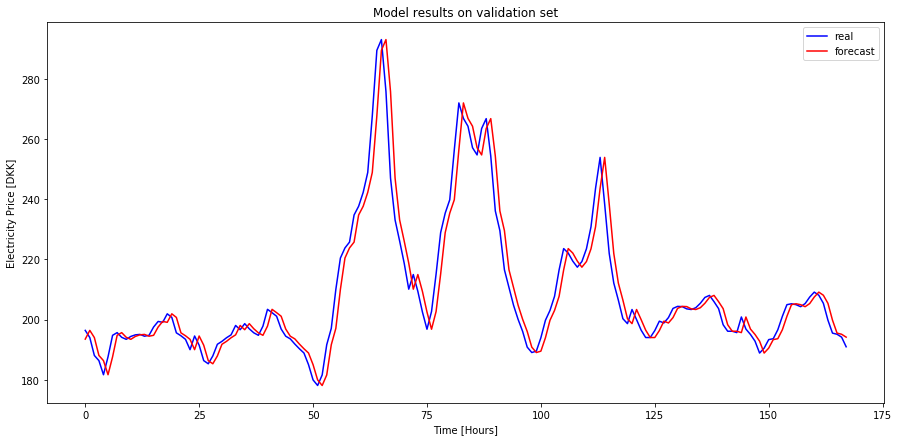

In [66]:
plot_sample_predictions(predictions_ensemble)

### IMPACT OF PREDICTION HORIZON ON MODEL PERFORMANCE

**Scope** 

The model developed in the previous steps is going to be applied to forecast hourly electricity price, simulating different scenarios:
* Given the electricity price at time *t* (and all the prior time-steps that we want), we can make predictions to estimate the electricity price at time *t+1*, *t+2* and so on.
* Given previous prediction, we can calculate the usal performance metrics (MAE and RMSE) and see how they change varying the horizon of prediction

In [ ]:
# features and label definition
n_features = 24 # how many time steps to consider for the analysis
time_interval = [0,1,2,3,4,5,6,7,8,9,10] # how many hour in advance the modell should make the prediction

# LSTM architecture
neurons = 3
epochs = 5

# internal paramters for the LSTM model
n_shift = n_features + time_interval - 1
n_ahead = range(0,time_interval)

n_ensemble = 1

In [ ]:
# preprocessing function

# MEMO independent from market region

In [ ]:
# for-loop model fitting with different time_interval

In [ ]:
# histogram